In [1]:
import networkx as nx
import numpy as np
from scipy.special import binom
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from tqdm.notebook import tqdm
import multiprocessing

np.random.seed(1234)

## Functions

### About Networks and Adjacency matrices

In [2]:
def linksBetween(A, groups, g1, g2):
    """
    Compute the number of links between two groups
    """
    l = 0
    for i in groups[g1]:
        for j in groups[g2]:
            l += A[i, j]
    return l


def maxBetween(groups, g1, g2):
    """
    Compute the maximum number of links between two groups
    """
    return len(groups[g1]) * len(groups[g2])


def findGroup(groups, i):
    """
    Find the group of a given node
    """
    for g, group in enumerate(groups):
        if i in group:
            return g
    
    return None


def swap(groups, i, g_new):
    """
    Swap a node i from group to group g
    """
    # Copy the groups data structure
    new_groups = copy.deepcopy(groups)
    
    # Swap the node
    g_old = findGroup(groups, i)
    new_groups[g_old].remove(i)
    new_groups[g_new].append(i)

    return new_groups


def getLinkLists(A):
    """
    Get the list of links and not links from the adjacency matrix
    """
    N = A.shape[0]
    
    links = []
    not_links = []

    for i in range(N):
        for j in range(i, N):
            if A[i, j] == 1:
                links.append((i, j))
            else:
                not_links.append((i, j))

    return links, not_links


def compareAdjacencyMatrices(A, A_obs):
    """
    Compare the adjacency matrices
    """
    A_links, A_not_links = getLinkLists(A)
    A_obs_links, A_obs_not_links = getLinkLists(A_obs)

    missing = [link for link in A_links if link not in A_obs_links]
    spurious = [link for link in A_obs_links if link not in A_links]

    return missing, spurious


def mirrorUpperTri(A):
    """
    Obtain undirected network overwriting the lower triangular part of A
    """
    N = A.shape[0]
    A = A.copy()
    for i in range(N):
        for j in range(i, N):
            A[j, i] = A[i, j]
    return A


def corruptAdjacencyMatrix(A, p, mode):
    """
    Corrupts the adjacency matrix A by adding missing and/or spurious edges
    """
    assert mode in ['missing', 'spurious', 'both'], "Invalid mode"
    assert p >= 0 and p <= 1, "Invalid probability"

    links, not_links = getLinkLists(A)
    
    # Edges to be potentially removed or added
    num_edges_to_remove = int(len(links) * p) 
    num_edges_to_add = int(len(not_links) * p) 
    if mode == "both":
        num_edges_to_remove = np.min([num_edges_to_remove // 2, num_edges_to_add // 2])
        num_edges_to_add = num_edges_to_remove
        
    A_corrupted = A.copy()

    if mode == 'missing' or mode == 'both':
        # Randomly select edges to remove and remove them
        edges_to_remove = np.random.choice(len(links), num_edges_to_remove, replace=False)
        for edge in edges_to_remove:
            i, j = links[edge]
            A_corrupted[i, j] = 0
            A_corrupted[j, i] = 0

    if mode == 'spurious' or mode == 'both':
        # Randomly select edges to add and add them
        edges_to_add = np.random.choice(len(not_links), num_edges_to_add, replace=False)
        for edge in edges_to_add:
            i, j = not_links[edge]
            A_corrupted[i, j] = 1
            A_corrupted[j, i] = 1

    # Ensure A = A.T
    A_corrupted = mirrorUpperTri(A_corrupted)

    return A_corrupted

### About sampling

In [3]:
def hamiltonian(A, groups):
    """
    Compute the Hamiltonian of the system
    """
    N = A.shape[0]

    def h(A, groups, g1, g2):
        r = maxBetween(groups, g1, g2)
        l = linksBetween(A, groups, g1, g2)
        return np.log(r+1) + np.log(binom(r, l)+1)
            
    H = 0
    for g2 in range(N):
        for g1 in range(g2+1):
            H += h(A, groups, g1, g2)
    
    return H


def singleStep(groups, H, A):
    """
    Perform a single step of the Metropolis-Hastings algorithm
    """
    N = A.shape[0]
    
    # Randomly select a node and a group
    i = np.random.randint(0, N)
    g_prop = np.random.randint(0, N)

    # Move the node to another group
    groups_prop = swap(groups, i, g_prop)
    
    # Compute the Hamiltonian of the new configuration
    H_prop = hamiltonian(A, groups_prop)

    # Acceptance probability
    if H_prop <= H:
        groups = groups_prop
        H = H_prop
    else:
        r = np.random.rand()
        if r < np.exp(H - H_prop):
            groups = groups_prop
            H = H_prop

    return groups, H


def samplingBranch(A, groups, n_samples, delay, seed, return_H=False):
    """
    Sampling algorithm (at equilibrium) to parallelize the computation
    """
    np.random.seed(seed)
    

    partitions_set = []
    hamiltonians_list = []

    H = hamiltonian(A, groups)

    for k in range(n_samples):
        for _ in range(delay):
            groups, H = singleStep(groups, H, A)
        partitions_set.append(groups)
        hamiltonians_list.append(H)

    if return_H:
        return partitions_set, hamiltonians_list
    else:
        return partitions_set
    

def parallelPartitionsSet(A, groups_init, n_samples, delay, n_cores=-1, return_H=True):
    """
    Get the set of partitions after the transient (at equilibrium)
    """
    if n_cores == -1:
       n_cores = multiprocessing.cpu_count()

    n_samples = int(n_samples) # Cast n_samples
    n_samples_per_core = n_samples//n_cores
    # if (n_samples_per_core*n_cores < n_samples):
    #     print("Warning: n_samples is not a multiple of n_cores, computing ", n_samples_per_core*n_cores, " samples instead.")

    seeds = np.random.randint(0, 2**32-1, n_cores) # Random seeds to avoid the same partitions
    input = [(A, groups_init, n_samples_per_core, delay, seeds[i], return_H) for i in range(n_cores)]

    with multiprocessing.Pool(processes=n_cores) as pool:
        results = pool.starmap(samplingBranch, input)

    if return_H:
        partitions_set = [item for sublist in [results[i][0] for i in range(n_cores)] for item in sublist]
        hamiltonians_list = [item for sublist in [results[i][1] for i in range(n_cores)] for item in sublist]
        return partitions_set, hamiltonians_list
    else:
        partitions_set = [item for sublist in results for item in sublist]
        return partitions_set
    

def generatePartitionsSet(A, n_samples, delay, transient, n_cores=-1, return_H=True):
    """
    Generate the set of partitions from the adjacency matrix A
    """
    # Groups data structure: list of lists
    N = A.shape[0]
    groups = [[] for _ in range(N)]

    # Uniformly random initialization
    for i in range(N): 
        g = np.random.randint(0, N)
        groups[g].append(i)

    # Transient
    H = hamiltonian(A, groups)
    for _ in range(transient):
        groups, H = singleStep(groups, H, A)
    
    return parallelPartitionsSet(A, groups, n_samples, delay, n_cores, return_H)

### About reliability

In [4]:
def singleLinkReliability(A, groups, i, j, H=None, return_H=False):
    """
    Reliability of a given link for a particular configuration
    """
    g_i = findGroup(groups, i)
    g_j = findGroup(groups, j)

    r = maxBetween(groups, g_i, g_j)
    l = linksBetween(A, groups, g_i, g_j)

    if H is None: H = hamiltonian(A, groups) # Possibly to save computation

    if return_H:
        return (l + 1)*np.exp(-np.float128(H))/(r + 2), H
    else:
        return (l + 1)*np.exp(-np.float128(H))/(r + 2)
    

def computeLinkReliabilityMatrix(A, partitions_set, hamiltionian_list=None):
    """
    Compute the link reliability matrix for a given configuration
    """
    if hamiltionian_list is not None: 
        assert len(partitions_set) == len(hamiltionian_list), "partitions_set and hamiltionian_list must have the same length"

    N = A.shape[0]
    link_reliability = np.zeros((N, N))
        
    if hamiltionian_list is not None:
        for i in range(N):
            for j in range(i, N):
                for k in range(len(partitions_set)):
                    link_reliability[i, j] += singleLinkReliability(A, partitions_set[k], i, j, hamiltionian_list[k])
    else:
        hamiltionian_list = []
        for i in range(N):
            for j in range(i, N):
                for k in range(len(partitions_set)):
                    l_r, H = singleLinkReliability(A, partitions_set[k], i, j, return_H=True)
                    link_reliability[i, j] += l_r
                    hamiltionian_list.append(H)


    # Symmetrize the matrix
    link_reliability = link_reliability + link_reliability.T - np.diag(np.diag(link_reliability))

    # Compute the partition function
    Z = np.sum(np.exp(-np.array(hamiltionian_list, dtype=np.float128)), dtype=np.float128)

    return link_reliability / Z


def sortLinkLists(links, not_links, link_reliability):
    """
    Sort the lists of links and not links according to their reliability
    """
    # Links: sort by increasing reliability
    links = sorted(links, key=lambda x: link_reliability[x[0], x[1]], reverse=False)
    # Not links: sort by decreasing reliability
    not_links = sorted(not_links, key=lambda x: link_reliability[x[0], x[1]], reverse=True)

    return links, not_links
   

def singleNetworkReliability(A, A_obs, groups, H=None, return_H=False):
    """
    Reliability of the network for a particular configuration
    """
    N = A.shape[0]
    
    def exp_element(A, A_obs, groups, g1, g2):
        r = maxBetween(groups, g1, g2)
        l = linksBetween(A, groups, g1, g2)
        l_obs = linksBetween(A_obs, groups, g1, g2)

        t1 = (r+1)/(2*r+1)
        t2 = binom(r, l_obs)/binom(2*r, l+l_obs)

        return np.log(t1) + np.log(t2)

    if H is None: H = hamiltonian(A, groups)

    sum_h = 0
    for g2 in range(N):
        for g1 in range(g2+1):
            sum_h += exp_element(A, A_obs, groups, g1, g2)
          
    n_r = np.exp(np.float128(sum_h - H))

    if return_H:
        return n_r, H
    else:
        return n_r
    

def getNetworkReliability(A, A_obs, partitions_set, hamiltionian_list=None):
    """
    Compute the network reliability
    """
    if hamiltionian_list is not None: 
        assert len(partitions_set) == len(hamiltionian_list), "partitions_set and hamiltionian_list must have the same length"

    network_reliability = 0

    if hamiltionian_list is not None:
        for k in range(len(partitions_set)):
            network_reliability += singleNetworkReliability(A, A_obs, partitions_set[k], hamiltionian_list[k])
    else:
        hamiltionian_list = []
        for k in range(len(partitions_set)):
            n_r, H = singleNetworkReliability(A, A_obs, partitions_set[k], return_H=True)
            network_reliability += n_r
            hamiltionian_list.append(H)

    Z = np.sum(np.exp(-np.array(hamiltionian_list, dtype=np.float128)), dtype=np.float128)
    
    return network_reliability / Z

### Visual

In [6]:
def plotGraphsComparison(A, A_obs, A_tilde):
    """
    Plot the comparison between the original, observed and reconstructed graphs
    """

    ##  Helper functions ##
    def degreeRelativeError(G, G_obs, cutoff=3):
        """
        Compute the relative error in the degree
        """
        assert cutoff > 0, "Invalid cutoff"

        deg = np.array(list(dict(G.degree()).values()))
        deg_obs = np.array(list(dict(G_obs.degree()).values()))

        deg_err_obs = (deg_obs-deg)/deg # Relative error in degree
        deg_err_obs[deg_err_obs > cutoff] = cutoff
        deg_err_obs[deg_err_obs < -cutoff] = -cutoff

        return deg_err_obs


    def diffGraph(A, A_obs):
        """
        Compute the graph with only missing and spurious interactions
        """
        # Create the graph and remove all the edges
        G_diff = nx.from_numpy_array(A)
        G_diff.remove_edges_from(list(G_diff.edges))

        # Add the missing and spurious edges
        missing, spurious = compareAdjacencyMatrices(A, A_obs)
        for m in missing: G_diff.add_edge(*m, color='red')
        for s in spurious: G_diff.add_edge(*s, color='blue')
        
        return G_diff
    
    
    def plotDiffGraph(A, A1, ax):
        """
        Plot the graph with only missing and spurious interactions
        """
        # Networks
        G = nx.from_numpy_array(A)
        G1 = nx.from_numpy_array(A1)
        bet1 = np.array(list(nx.betweenness_centrality(G1).values()))
        deg_err = degreeRelativeError(G, G1, cutoff=3)

        # Node cmap and colorbar
        norm = mcolors.Normalize(vmin=-3, vmax=3)
        cmap = plt.get_cmap('RdYlBu')
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Degree relative error', orientation='horizontal', fraction=0.04, pad=0.1)

        # Plot
        G_diff = diffGraph(A, A1)
        node_colors = cmap(norm(deg_err))
        edge_colors = nx.get_edge_attributes(G_diff,'color').values()
        nx.draw(G_diff, ax=ax, pos=layout, with_labels=False,
                node_color=node_colors, node_size=(300+2000*bet1), cmap=cmap,
                edge_color=edge_colors, width=1)
        
        nx.draw(G1, ax=ax, pos=layout, with_labels=False,
                node_color='none', node_size=(300+2000*bet), edgecolors='black', linewidths=1,
                edge_color='grey', width=0)

        # Custom legend
        custom_lines = [plt.Line2D([0], [0], color='red', lw=2),
                        plt.Line2D([0], [0], color='blue', lw=2),
                        plt.Line2D([0], [0], color='#E8E9EB', lw=2)]
        ax.legend(custom_lines, ['Missing', 'Spurious', 'Correct not shown'], loc='lower center',
                    bbox_to_anchor=(0.5, -0.1), ncol=3)



    ## Networks ##
    G = nx.from_numpy_array(A)
    bet = np.array(list(nx.betweenness_centrality(G).values())) # Betweenness centrality
    

    ## Plots ##
    layout = nx.spring_layout(G)
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 6))
    # Original network
    ax[0].set_title("Original network")
    nx.draw(G, ax=ax[0], pos=layout, with_labels=False, 
            node_color='skyblue', node_size=(300+2000*bet), edgecolors='black', linewidths=1,
            edge_color='gray')
    
    # Observed network
    ax[1].set_title("Observed network")
    plotDiffGraph(A, A_obs, ax[1])

    # Reconstructed network
    ax[2].set_title("Reconstructed network")
    plotDiffGraph(A, A_tilde, ax[2])

    fig.tight_layout()
    fig.patch.set_facecolor('#E8E9EB')

    return fig, ax

## Code

In [167]:
# Adjacency matrix (undirected graph with self-loops)
N = 30
upper_triangular = np.triu(np.random.randint(0, 2, size=(N, N)), 1)
A = mirrorUpperTri(upper_triangular)
np.fill_diagonal(A, np.random.randint(0, 2, size=N))

upper_triangular = np.triu(np.random.randint(0, 2, size=(N, N)), 1)
A_obs = upper_triangular + upper_triangular.T
np.fill_diagonal(A_obs, np.random.randint(0, 2, size=N))

Number of nodes: 15


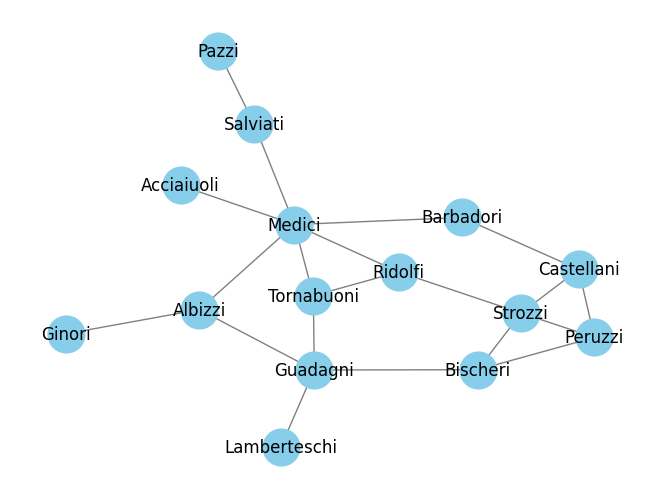

In [5]:
# Get the Karate Club network
G = nx.karate_club_graph().to_undirected()
G = nx.florentine_families_graph().to_undirected()

A = nx.adjacency_matrix(G).todense()
A = (A > 0).astype(int)
N = A.shape[0]

print("Number of nodes:", N)

nx.draw(G, with_labels=True, node_color='skyblue', node_size=700, font_size=12, font_color='black', edge_color='gray')

### Trials

In [6]:
A_obs = corruptAdjacencyMatrix(A, p=0.2, mode='both')
A_obs

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],
       [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0],
       [0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0],
       [0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1],
       [0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1],
       [0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0],
       [0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1],
       [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0]])

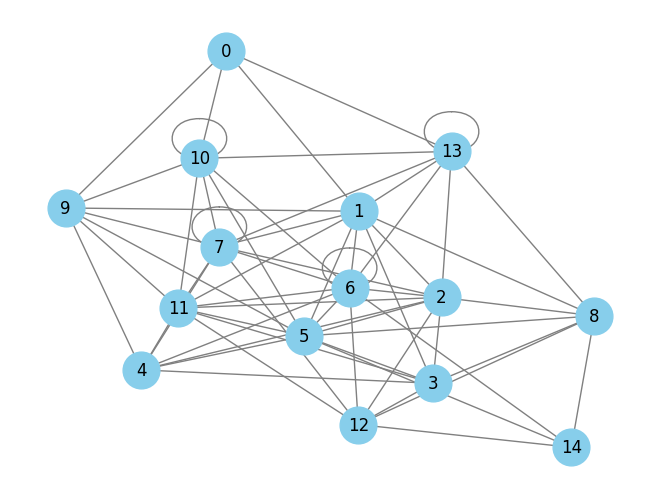

In [7]:
G_obs = nx.from_numpy_array(A_obs)
nx.draw(G_obs, with_labels=True, node_color='skyblue', node_size=700, font_size=12, font_color='black', edge_color='gray')

In [8]:
# Groups data structure: list of lists
groups = [[] for _ in range(N)]

# Uniformly random initialization
for i in range(N): 
    g = np.random.randint(0, N)
    groups[g].append(i)

# Transient time (to test convergence)
H = hamiltonian(A_obs, groups)

transient_history = [H]

# Transient
transient = 10000
for k in range(transient):
    print("Progress: ", k, "/", transient, end="\r")
    groups, H = singleStep(groups, H, A_obs)

    transient_history.append(H)

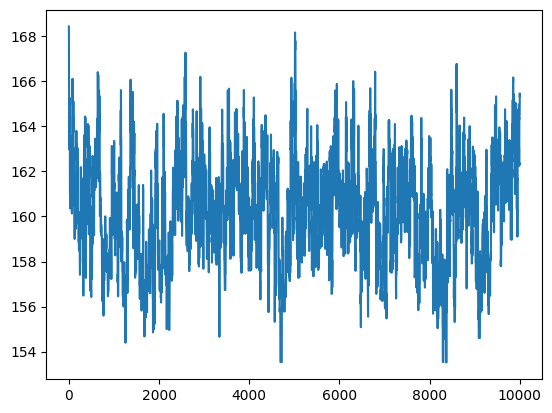

In [9]:
plt.plot(transient_history)

In [25]:
# # Equilibrium (not in parallel)
# delay = 50 # for uncorrelate the samples
# n_samples = 20
# partitions_set = []

# for k in tqdm(range(n_samples)):
#     for _ in range(delay):
#         groups, H = singleStep(groups, H, A)
#     partitions_set.append(groups)

In [26]:
# Equilibrium: get the set of partitions
partitions_set, hamiltionian_list = parallelPartitionsSet(A, groups, n_samples=20, delay=20, n_cores=-1, return_H=True)

### Network Reconstruction

In [18]:
A

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]])

In [46]:
# Currupt the adjacency matrix
A_obs = corruptAdjacencyMatrix(A, p=0.1, mode='both')
A_obs

array([[0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
       [0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1],
       [0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0]])

In [47]:
np.sum(A_obs == A) / N**2

np.float64(0.9066666666666666)

In [57]:
# Initialize the current adjacency matrix
A_cur = A_obs.copy()

for _ in range(5): # This should be a stopping criterion
    
    # Generate the set of partitions and the Hamiltonian list
    partitions_set, hamiltionian_list = generatePartitionsSet(A_cur, n_samples=1e4, delay=20, transient=500, n_cores=-1, return_H=True)

    # Compute the network reliability and the link reliability matrix
    R_N = getNetworkReliability(A_cur, A_obs, partitions_set, hamiltionian_list)
    R_L = computeLinkReliabilityMatrix(A_cur, partitions_set, hamiltionian_list)
    print(_, " , R_N: ", R_N, "acc: ", np.sum(A_cur == A)/N**2)

    # Sort the links (increasing R) and not links (decreasing R)
    sorted_links, sorted_not_links = sortLinkLists(*getLinkLists(A_cur), R_L)

    # Iterate to reconstruct the network
    iterations = np.min([len(sorted_links), len(sorted_not_links)])
    miss_update = 0
    for k in range(np.min([len(sorted_links), len(sorted_not_links)])):
        # Choose a pair of link and not link in order
        link, not_link = sorted_links[k], sorted_not_links[k]

        # Swap the links
        A_temp = A_cur.copy()
        A_temp[link[0], link[1]] = 0
        A_temp[link[1], link[0]] = 0
        A_temp[not_link[0], not_link[1]] = 1
        A_temp[not_link[1], not_link[0]] = 1

        # Compute the network reliability with the new adjacency matrix
        partitions_set_temp, hamiltionian_list_temp = generatePartitionsSet(A_temp, n_samples=1e4, delay=20, transient=500, n_cores=-1, return_H=True)
        R_N_temp = getNetworkReliability(A_temp, A_obs, partitions_set_temp, hamiltionian_list_temp)
        
        # If the network reliability increases, update the adjacency matrix
        if R_N_temp > R_N:
            print("OK")
            A_cur = A_temp
            R_N = R_N_temp
            miss_update = 0
        else:
            miss_update += 1
            if miss_update > 4:
                print("R_N: ", R_N, "acc: ", np.sum(A_cur == A)/N**2, " then break")
                break
            
        print("R_N: ", R_N, "acc: ", np.sum(A_cur == A)/N**2)
        



0  , R_N:  1.3974857156211945835e-21 acc:  0.9422222222222222
OK
R_N:  6.533460175919362855e-21 acc:  0.9377777777777778
OK
R_N:  1.3842373443088935926e-19 acc:  0.92
OK
R_N:  5.6410948996668053762e-19 acc:  0.9022222222222223
OK
R_N:  2.4548716582983529464e-18 acc:  0.8844444444444445
OK
R_N:  3.0502191094950466173e-17 acc:  0.8844444444444445
OK
R_N:  1.3438355218925779622e-16 acc:  0.8844444444444445
OK
R_N:  1.7675436256585904317e-16 acc:  0.8666666666666667
OK
R_N:  2.1773481801957181914e-15 acc:  0.8666666666666667
OK
R_N:  4.085332449553231761e-15 acc:  0.8666666666666667
R_N:  4.085332449553231761e-15 acc:  0.8666666666666667
OK
R_N:  4.6158160220952383892e-15 acc:  0.8488888888888889
R_N:  4.6158160220952383892e-15 acc:  0.8488888888888889
R_N:  4.6158160220952383892e-15 acc:  0.8488888888888889
OK
R_N:  4.8011846378716616214e-15 acc:  0.8311111111111111
OK
R_N:  7.347220998487611793e-15 acc:  0.8133333333333334
R_N:  7.347220998487611793e-15 acc:  0.8133333333333334
R_N:  7.3

KeyboardInterrupt: 

In [54]:
A_obs = corruptAdjacencyMatrix(A, p=0.05, mode='both')
np.sum(A_obs == A) / N**2

np.float64(0.9422222222222222)

In [55]:
partitions_set, hamiltionian_list = generatePartitionsSet(A_obs, n_samples=1e4, delay=20, transient=500, n_cores=-1, return_H=True)
R_N = getNetworkReliability(A_obs, A_obs, partitions_set, hamiltionian_list)
R_N

np.longdouble('1.7005197854430113481e-21')

In [56]:
partitions_set, hamiltionian_list = generatePartitionsSet(A, n_samples=1e4, delay=20, transient=500, n_cores=-1, return_H=True)
R_N = getNetworkReliability(A, A_obs, partitions_set, hamiltionian_list)
R_N

np.longdouble('2.9431138898494523337e-19')

### Link reliability

### Visual

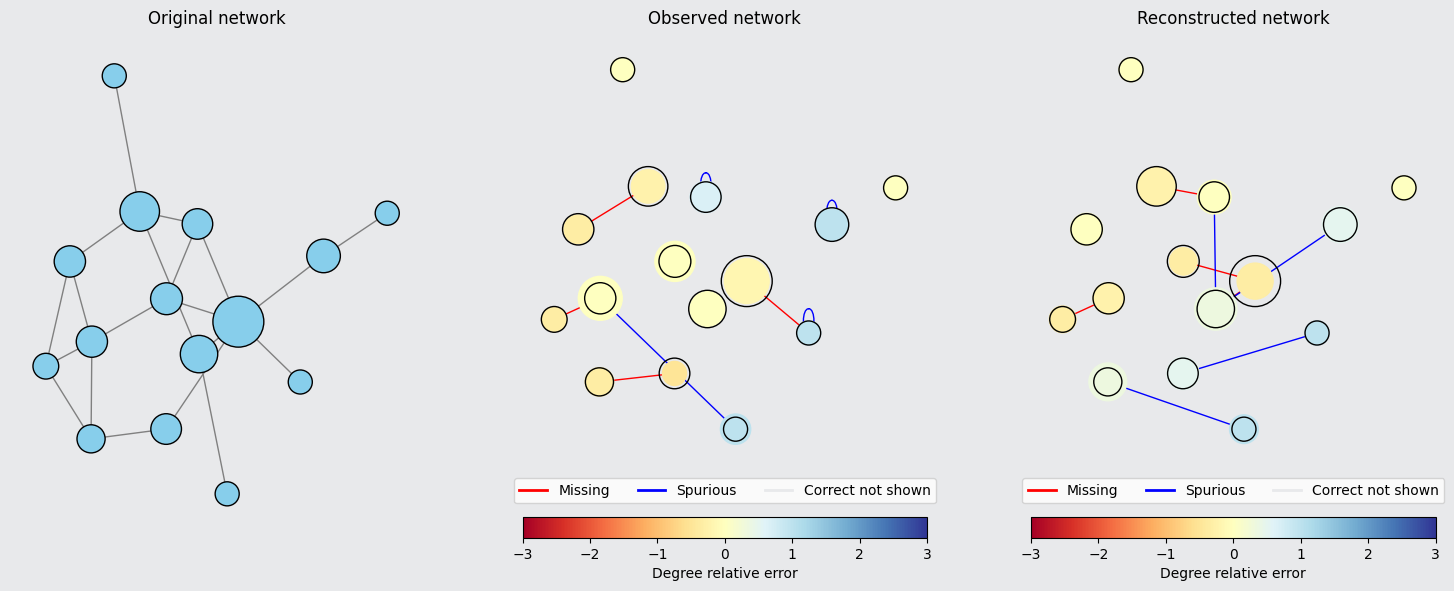

In [8]:
G = nx.florentine_families_graph().to_undirected()
#G = nx.karate_club_graph().to_undirected()
A = nx.adjacency_matrix(G).todense()
del G
A_obs = corruptAdjacencyMatrix(A, p=0.4, mode='both')
A_tilde = corruptAdjacencyMatrix(A, p=0.4, mode='both')

fig, ax = plotGraphsComparison(A, A_obs, A_tilde)
fig.show()